# The surface of revolution of minimum area

The well-known surface of revolution of minimum area problem dates back to Euler. This is a problem of calculus of variations for which it is easy to have the analytic solutions. But here, as we use this simple problem to illustrate the use of the `control-toolbox`, we consider the optimal control version:

$$
    \left\{\begin{array}{l}
    \displaystyle \min\, \int_0^{2} x(t)\,\sqrt{1+u^2(t)}\,\mathrm{d}t\\[1em]
    \dot{x}(t) = u(t), \quad u(t)\in\R, \\[0.5em]
    x(0) = 1, \quad x(2) = 1.
    \end{array}
    \right.
$$

## Packages

In [125]:
using Pkg
Pkg.activate(".")
#
using DifferentialEquations
using ForwardDiff
using LaTeXStrings
using LinearAlgebra
using OptimalControl
using Plots
using Roots     # solve an equation f(x)=0 where f is from R to R
using Test

## Control-toolbox definition of the problem

To define this problem in our package we have to type:

In [126]:
t0 = 0
tf = 1
x0 = 1
xf = 2.5
@def ocp begin
    t ∈ [ t0, tf ], time
    x ∈ R, state
    u ∈ R, control
    x(t0) == x0
    x(tf) == xf
    ẋ(t) ==  u(t)
    ∫(x(t)*(1 + u(t)^2)^(1/2)) → min
end

t ∈ [t0, tf], time
x ∈ R, state
u ∈ R, control
x(t0) == x0
x(tf) == xf
ẋ(t) == u(t)
∫(x(t) * (1 + u(t) ^ 2) ^ (1 / 2)) → min



┌───────┬───────┬─────────┬──────────┬───────────┬─────────────┐
│ times │ state │ control │ dynamics │ objective │ constraints │
├───────┼───────┼─────────┼──────────┼───────────┼─────────────┤
│    ✅ │    ✅ │      ✅ │       ✅ │        ✅ │          ✅ │
└───────┴───────┴─────────┴──────────┴───────────┴─────────────┘


## Hamiltonian flow

The pseudo-Hamiltonian is
$$H(x,p,u) =  -x\sqrt{1+u^2} + up,$$
and for $|p| < |x|$ the maximization of the pseudo-Hamiltonian provides the control with respect to the state and the costate (or covector):
$$u(x,p) = \mathrm{sign}(x) \frac{p}{\sqrt{x^2-p^2}}.$$

Then, we can define the Hamiltonian $\mathbf{H}(x,p)=H(x, p, u(x,p))$.
We note $z(t) = (x(t),p(t))$, then, the Hamiltonian flow is the function
$\phi(\cdot, z_0) = \phi(\cdot, x_0, p_0)$ solution of the initial value problem

$$
    \dot{z} = \vec{\mathbf{H}}(z) = (\dot{x}, \dot{p}) =
    \left(
        \dfrac{\partial \mathbf{H}}{\partial p}(z), 
        -\dfrac{\partial \mathbf{H}}{\partial x}(z)
    \right), \quad
    z(0) = z_0 = (x_0,p_0).
$$

In [127]:
# Control in feedback form
u(x, p) = sign(x) * p / sqrt(x^2-p^2)

# The Flow function computes the Hamiltonian flow
ocp_flow = Flow(ocp, u, reltol=1e-10, abstol=1e-10);

p0 = -0.985
p0 = -0.999


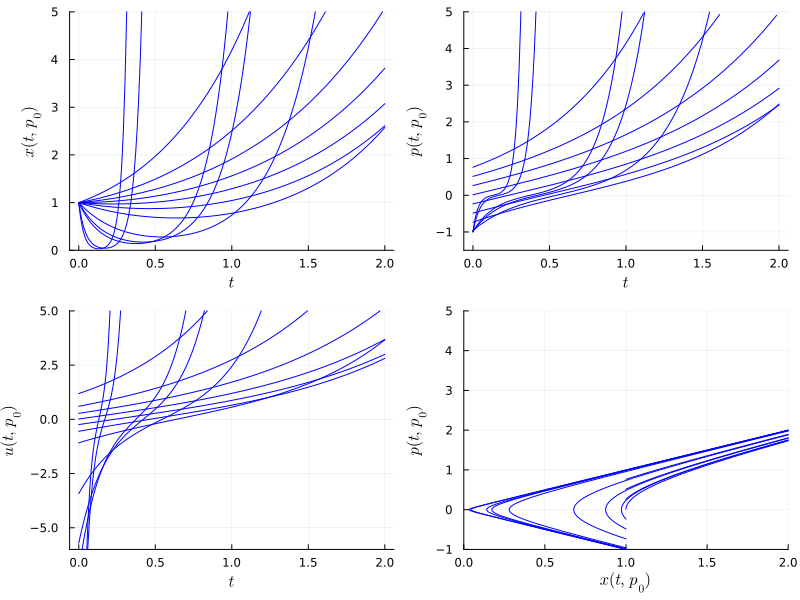

In [211]:
# Compute flows for different values of the initial costate p_0
p0s = collect(-0.985:0.25:0.98)      # interval of p_0
append!(p0s,[-0.96, -0.99, -0.999, -0.9995])
N = 200
tf = 2
tspan = range(t0, tf, N)    # time interval
plt_x = plot()              # plot of the state x(t)
plt_p = plot()              # plot of the costate p(t)
plt_u = plot()              # plot of the control u(t)
plt_phase = plot()          # plot (x, p)
color_trajectory = :blue
color_trajectory2 = :blue   # :green for seeing the value the  to  extremals

 # callback: termination
 # Without this, the numerical integration stop before tf for p_0 = 0.99
condition(z,t,integrator) = z[1] - 5.
affect!(integrator) = terminate!(integrator)
cbt  = ContinuousCallback(condition,affect!)

for i in 1:length(p0s) # plot for each p_0 in p0s 
    p0 = p0s[i]
    flow_p0 = ocp_flow((t0, tf), x0, p0, saveat=tspan,callback=cbt)
    T = flow_p0.ode_sol.t
    n_T = length(T)
    Z = flow_p0.(T)
    X = [Z[i][1] for i in 1:n_T]
    P = [Z[i][2] for i in 1:n_T]
    if i==1 || i==length(p0s)-1
        println("p0 = ", p0)
        plot!(plt_x, T, X, color=color_trajectory2)
        plot!(plt_p, T, P, color=color_trajectory2)
        plot!(plt_u, T, u.(X, P), color=color_trajectory2)  
        plot!(plt_phase, X, P, color=color_trajectory2)
    else    
        plot!(plt_x, T, X, color=color_trajectory)
        plot!(plt_p, T, P, color=color_trajectory)
        plot!(plt_u, T, u.(X, P), color=color_trajectory)  
        plot!(plt_phase, X, P, color=color_trajectory)
    end

end

# Plots
plot!(plt_x, xlabel=L"t", ylabel=L"x(t,p_0)", legend=false, ylims=(0.,5.))
plot!(plt_p, xlabel=L"t", ylabel=L"p(t,p_0)", legend=false, ylims=(-1.5,5.))
plot!(plt_u, xlabel=L"t", ylabel=L"u(t,p_0)", legend=false, ylims=(-6.,5.))
plot!(plt_phase, xlabel=L"x(t,p_0)", ylabel=L"p(t,p_0)", legend=false, xlims=(0.,2.), ylims=(-1.,5.))

fig1_example1 = plot(plt_x, plt_p, plt_u, plt_phase, layout=(2,2), size=(800,600))
Plots.pdf(fig1_example1, "./fig-example1/fig1_example1.pdf")
plot(fig1_example1)

## Extremals for the original problem
First, we define the  shooting function 
$ S({p_0}) = \pi(z(t_f,x_0,{p_0})) - x_f,$ 
and then we solve the shooting equation $S(p_0)=0$.

In [167]:
# Shooting function
π((x, p)) = x

tf = 1
xf = 2.5
S(p0) = (π ∘ ocp_flow)(t0, x0, p0, tf) - xf

# Solve the shooting equation
# First extremal
p0 = -0.985
sol1_p0 = Roots.find_zero(S, (-0.99, -0.97))
# Second extremal
p0 = 0.515
sol2_p0 = Roots.find_zero(S, (0.5, 0.6))

0.5126502880904497

In [168]:
println("sol1_p0 = ", sol1_p0)
println("S(sol1_p0) = ", S(sol1_p0))
println("sol2_p0 = ", sol2_p0)
println("S(sol2_p0) = ", S(sol2_p0))

sol1_p0 = -0.9851008114498444
S(sol1_p0) = 

-2.8954616482224083e-13
sol2_p0 = 0.5126502880904497
S(sol2_p0) = -8.881784197001252e-16


p0 = -0.9851008114498444
p0 = 0.5126502880904497


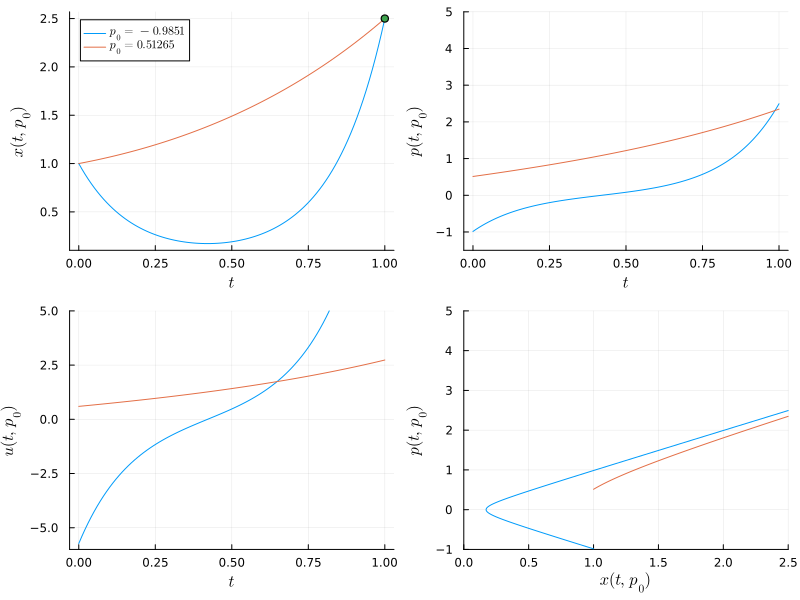

In [169]:
# Compute flows for different values of the initial costate p_0
p0s = (sol1_p0,sol2_p0)      # interval of p_0
tf = 1
N = 100
tspan = range(t0, tf, N)    # time interval
plt2_x = plot()              # plot of the state x(t)
plt2_p = plot()              # plot of the costate p(t)
plt2_u = plot()              # plot of the control u(t)
plt2_phase = plot()          # plot (x, p)

labels = [L"p_0=-0.9851" , L"p_0=0.51265"]
for i in 1:length(p0s) # plot for each p_0 in p0s 
    p0 = p0s[i]
    
    flow_p0 = ocp_flow((t0, tf), x0, p0, saveat=tspan)

    T = tspan
    Z = flow_p0.(tspan)
    X = [Z[i][1] for i in 1:N]
    P = [Z[i][2] for i in 1:N]
    println("p0 = ", p0)
    plot!(plt2_x, T, X, label=labels[i])
    plot!(plt2_p, T, P, label=labels[i])
    plot!(plt2_u, T, u.(X, P), label=labels[i])  
    plot!(plt2_phase, X, P, label=labels[i])
end

# Plots
plot!(plt2_x, [tf], [xf], xlabel=L"t", ylabel=L"x(t,p_0)", seriestype=:scatter,label="")
plot!(plt2_p, xlabel=L"t", ylabel=L"p(t,p_0)", legend=false, ylims=(-1.5,5.))
plot!(plt2_u, xlabel=L"t", ylabel=L"u(t,p_0)", legend=false, ylims=(-6.,5.))
plot!(plt2_phase, xlabel=L"x(t,p_0)", ylabel=L"p(t,p_0)", legend=false, xlims=(0.,2.5), ylims=(-1.,5.))

fig1bis_example1 = plot(plt2_x, plt2_p, plt2_u, plt2_phase, layout=(2,2), size=(800,600))
# plot(plt2_x, xlabel=L"t", ylabel=L"x(t,p_0)", size=(400,300))
Plots.pdf(fig1bis_example1, "./fig-example1/fig1bis_example1.pdf")
plot(fig1bis_example1)

## Conjugate points

The time $\tau$ is said to be conjugate to the the time $t_0=0$ if the solution of the Jacobi equation
$$
\delta\dot{z}(t) = \dfrac{\partial \vec{\mathbf{H}}}{\partial z}(z(t,z_0)) \cdot \delta z(t)
$$
with the initial condition
$\delta z(0) = (0, 1)$, is vertical at time $\tau$, that is if $\delta x(\tau) = 0$.

We first compute by automatic differentiation the flow of the Jacobi equation with the initial condition 
$$\delta z(t,x_0,p_0)=\dfrac{\partial z}{\partial p_0}z(t,x_0,p_0)$$ 


In [170]:
#
# Conjugate points

"""
    Compute the flow of the Jacobi equation for the initial condition δz(0) = (0,1)
    sol = jacobi_flow(T,x0,p0)
    input : 
    T : time where we want δz(t) 
        list or array (t0,t1,...,tN)
    x0 : initial state
         Real(n), here a real
    p0 : initial costate
         Real(n), here a real
    output : 
    sol : (δz(t0),δz(t1),...,δz(tN))
          Vector of vector of dimension 2n, the type of the element are the same as the type of p0 because we use after the automatic differentiation.
          To modifie if n > 1

""";


In [171]:
π((x, p)) = x

function jacobi_flow(t, p0)
    x(t, p0) = (π ∘ ocp_flow)(t0, x0, p0, t)
    return ForwardDiff.derivative(p0 -> x(t, p0), p0)
end

jacobi_flow (generic function with 1 method)

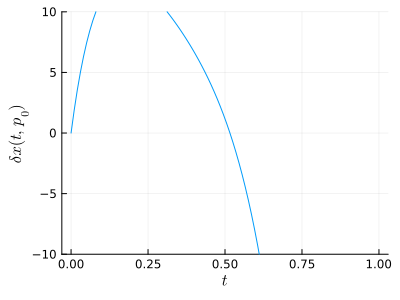

In [172]:
p0 = sol1_p0

N = 100
tspan = range(t0, tf, N) # time interval

δx = jacobi_flow.(tspan, p0)

plt_conj1 = plot()
plot!(plt_conj1, tspan, δx)  # as n=1 the det(δx) = δx
plot!(plt_conj1, xlabel=L"t", ylabel=L"\delta x(t,p_0)", legend=false, ylims=(-10.,10.), size=(400,300))

Plots.pdf(plt_conj1, "./fig-example1/fig2_example1.pdf")
plot(plt_conj1)


Then we numerically compute the conjugate point by solving $\delta x(t)=\delta z(t,x_0,p_0)_1=0$, for $x_0=1.$ and $p_0=0.985$.

In [173]:
# Compute the fisrt conjugate time
p0 = sol1_p0
tau0 = Roots.find_zero(tau -> jacobi_flow(tau, p0), (0.4, 0.6))

0.5159924382475679

For p0 = -0.9851008114498444 tau_0 = 0.5159924382475679


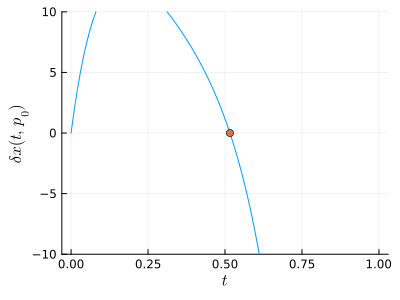

In [174]:
println("For p0 = ", p0, " tau_0 = ", tau0)

plot!(plt_conj1, [tau0], [jacobi_flow(tau0, p0)], seriestype=:scatter)

Plots.pdf(plt_conj1, "./fig-example1/fig3_example1.pdf")
plot(plt_conj1)

And for the second solution there is no conjugate point.

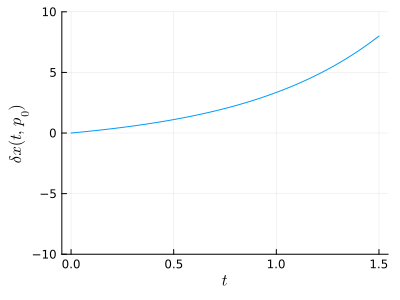

In [175]:
p0 = sol2_p0
tf=1.5
N = 100
tspan = range(t0, tf, N) # time interval

δx = jacobi_flow.(tspan, p0)

plt_conj1 = plot()
plot!(plt_conj1, tspan, δx)  # as n=1 the det(δx) = δx
plot!(plt_conj1, xlabel=L"t", ylabel=L"\delta x(t,p_0)", legend=false, ylims=(-10.,10.), size=(400,300))

Plots.pdf(plt_conj1, "./fig-example1/fig2bis_example1.pdf")
plot(plt_conj1)

## Compute the conjugate locus

We compute conjugate loci by path following algorithm

We define $F(\tau,p_0) = \delta x(\tau,p_0)$ and we suppose that 
$\dfrac{\partial F}{\partial\tau}(\tau,p_0)$ is  inversible, then by the implicit function theorem the conjugate time is a function of $p_0$. So, as here $p_0\in\R$, we can compute them by solving the initial value problem
$$(IVP_{conj.points})\left\{
\begin{array}{l}
\dot{\tau} = -\dfrac{\partial F}{\partial\tau}(\tau,p_0)^{-1}\dfrac{\partial F}{\partial p_0}(\tau,p_0)\\
\tau(p_0) = \tau_0.
\end{array}
    \right.$$

### Remark
The derivative $\dfrac{\partial F}{\partial\tau}(\tau,p_0) = \dfrac{\partial \delta x}{\partial\tau}(\tau,p_0)$ is equal to  the first component of the second member of the Jacobi equation
$\dfrac{\partial \vec{H}}{\partial z}(z(t,z_0))\delta z(t)$.


In [176]:
"""
    Compute the right hand side of the conj.points IVP equation
    tau_point = rhs_path(tau , par, p0)
    For the structure of the rhs_path see DifferentialEquaions package
""";

In [177]:
# conjugate points by path following
function conjugate_times_rhs_path(tau, p0)
    dF = ForwardDiff.gradient(y -> jacobi_flow(y...), [tau, p0])
    return -dF[2]/dF[1]
end

conjugate_times_rhs_path (generic function with 1 method)

In [178]:
"""
   Compute the conjugate times by path by integration of the (IVP_conj.points) problem
"""
function conjugate_times(p0span, tau0)
    ode = DifferentialEquations.ODEProblem((tau, par, p0) -> conjugate_times_rhs_path(tau, p0), tau0, p0span)
    sol = DifferentialEquations.solve(ode, reltol=1e-8, abstol=1e-8)
    return sol.u, sol.t # taus, p0s
end


conjugate_times

p0 = -0.9851008114498444
tau0 = 0.5159924382475679


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /Users/gergaud/.julia/packages/SciMLBase/2HZ5m/src/integrator_interface.jl:576


p0s[1] = -0.9995


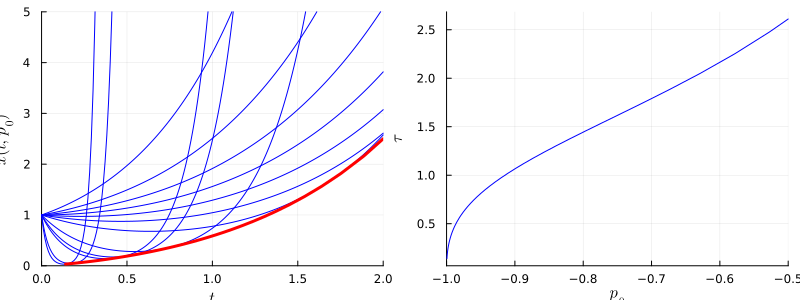

In [212]:
# conjugate locus
p0 = sol1_p0

println("p0 = ", p0)
println("tau0 = ", tau0)

taus1, p0s1 = conjugate_times((p0, -0.5), tau0)
taus2, p0s2 = conjugate_times((p0, -0.9995), tau0)

taus = append!(taus2[end:-1:1],taus1)
p0s = append!(p0s2[end:-1:1],p0s1)
# plot tau(p0)
plt_conj_times = plot(p0s, taus, xlabel = L"p_0", ylabel = L"\tau", color=color_trajectory, xlims = (-1,-0.5))

println("p0s[1] = ", p0s[1])

# get conjugate points
X = []
for (tau, p0) ∈ zip(taus, p0s)
    # compute x(tau, p0)
    x = (π ∘ ocp_flow)(t0, x0, p0, tau)
    push!(X, x)
end

# plot conjugate points on plt_x
plot!(plt_x, taus, X, linewidth=3, color=:red, legend=false, xlims=(0.,2.0), ylims=(0.,5.))

# 
plt_conj2 = plot(plt_x, plt_conj_times, layout=(1,2), legend=false, size=(800,300))

#
Plots.pdf(plt_conj2, "./fig-example1/fig4_example1.pdf")
plot(plt_conj2)

In [213]:
println("taus  = ", taus)
println("p0s = ", p0s)

taus  = [0.1405692161199269, 0.15282407875866455, 0.16871069174253062, 0.18591451698959052, 0.20451915093186526, 0.2246133410741572, 0.24629103439050368, 0.2696523458455048, 0.2948017803146935, 0.3218527931572141, 0.3508884690873623, 0.3820499166333496, 0.4148981220200288, 0.45026804213305277, 0.4763179282907825, 0.5159924382475679, 0.5159924382475679, 0.5622488935844842, 0.5854550907838346, 0.6186218991732587, 0.6468461719152666, 0.6785411456511786, 0.7097364568219942, 0.7428262325785212, 0.776824040924329, 0.8125149497787926, 0.849750923754472, 0.8888950273177247, 0.9300663294816213, 0.9735506255863507, 1.0195992774915041, 1.0685507318772876, 1.1207887357487134, 1.1767881977620864, 1.2371350680910718, 1.302564465621837, 1.374019244544396, 1.4527349854160025, 1.5403772272563798, 1.6392765032185146, 1.7528591116204464, 1.886521125466561, 2.0493359172091563, 2.2516927594740204, 2.476348390715729, 2.610677774050514]
p0s = [-0.9995, -0.9993824928678788, -0.9992063368521311, -0.99898322107

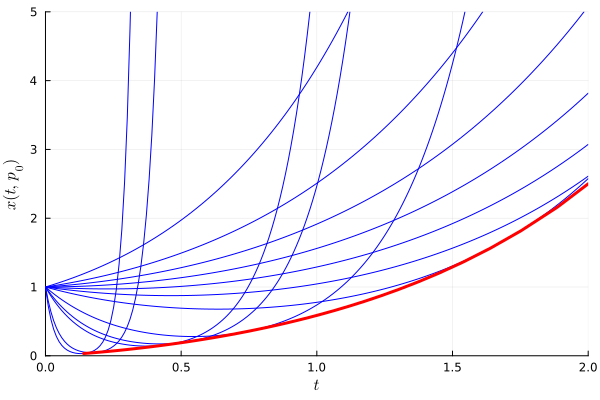

In [214]:
plot(plt_x)